In [8]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calculating neutrino phase-space distributions.

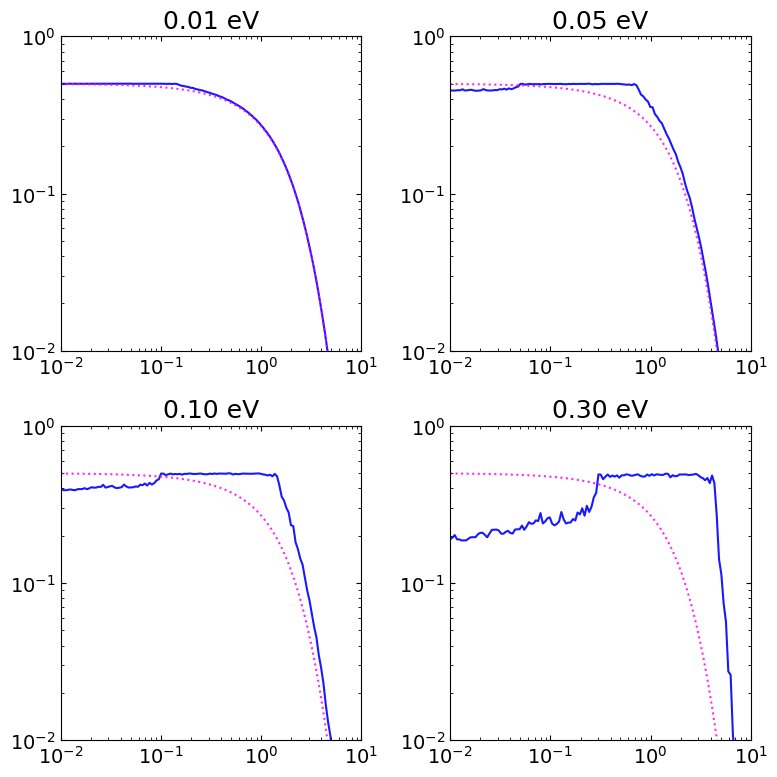

In [9]:
# Load neutrino velocities
file_name = 'neutrino_vectors_numerical_halo13'

nu_vels = jnp.array([
    jnp.load(f'Data/{file_name}_batch{i+1}.npy')[...,3:6]
    for i in range(8)
]).reshape(-1,100,3)

# Convert velocities to momenta
nu_masses = jnp.array([0.01, 0.05, 0.1, 0.3])
p_arr, y_arr = Physics.velocities_to_momenta(nu_vels, nu_masses, Params())

# Select neutrino with highest Fermi-Dirac value of each momentum batch
p_back, y_init = Physics.filter_momenta(p_arr, y_arr, len(nu_masses), Params())
p_init = y_init*Params.T_CNB

# Fermi-Dirac values
f_today = Physics.Fermi_Dirac(p_back, Params())

# Plot phase-space distribution
plt.figure()
for i, m_nu in enumerate(nu_masses):
    plt.subplot(221 + i)

    # Simulation
    plt.plot(y_init[i], f_today[i],
             label='Simulation', c='blue', alpha=0.9)

    # Original Fermi-Dirac
    p_Fermi_Dirac = jnp.geomspace(
        Params.p_start*Params.T_CNB, Params.p_stop*Params.T_CNB,
        f_today.shape[-1])
    y_Fermi_Dirac = p_Fermi_Dirac/Params.T_CNB
    f_Fermi_Dirac = Physics.Fermi_Dirac(p_Fermi_Dirac, Params())
    plt.plot(y_Fermi_Dirac, f_Fermi_Dirac,
             label='Fermi-Dirac', c='magenta', ls=':', alpha=0.85)

    plt.title(f'{m_nu:.2f} eV')
    plt.ylim(1e-2, 1e0)
    plt.xlim(Params.p_start, 1e1)
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()
plt.close()

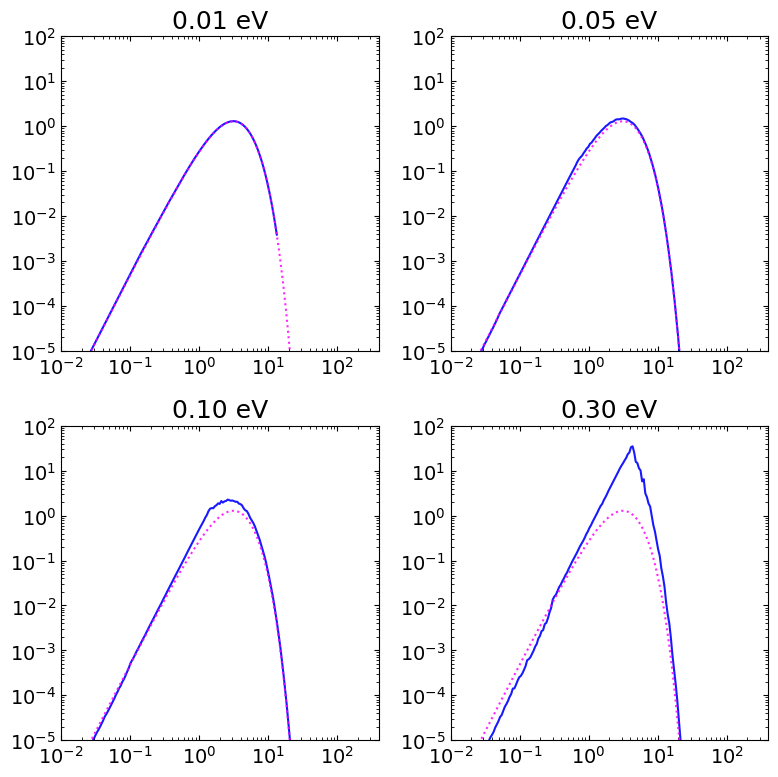

In [10]:
# Plot momentum distribution
plt.figure()
for i, m_nu in enumerate(nu_masses):
    plt.subplot(221 + i)

    # Simulation
    plt.plot(y_init[i], y_init[i]**3*f_today[i],
             label='Simulation', c='blue', alpha=0.9)

    # Original Fermi-Dirac
    p_Fermi_Dirac = jnp.geomspace(
        Params.p_start*Params.T_CNB, Params.p_stop*Params.T_CNB,
        f_today.shape[-1])
    y_Fermi_Dirac = p_Fermi_Dirac/Params.T_CNB
    f_Fermi_Dirac = Physics.Fermi_Dirac(p_Fermi_Dirac, Params())
    plt.plot(y_Fermi_Dirac, y_Fermi_Dirac**3*f_Fermi_Dirac,
             label='Fermi-Dirac', c='magenta', ls=':', alpha=0.85)

    plt.title(f'{m_nu:.2f} eV')
    plt.ylim(1e-5, 1e2)
    plt.xlim(Params.p_start, Params.p_stop)
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()
plt.close()

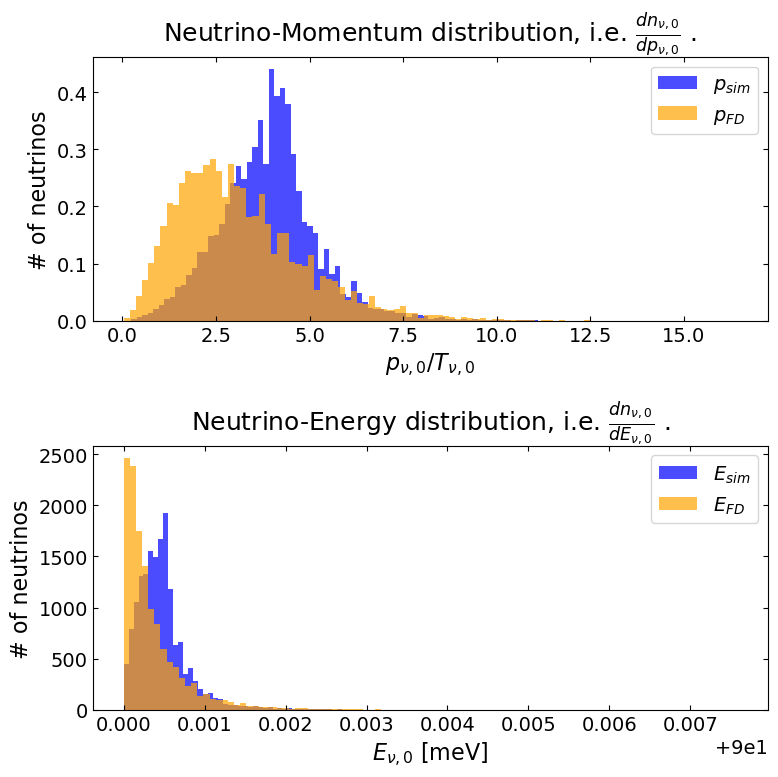

In [11]:
# Choose mass index
m_idx = -1

interpolation_type = 'cubic'

# Interpolate y_init**3*f_today = y_cubed_f
y_cubed_f = y_init[m_idx]**3*f_today[m_idx]
y_cubed_f_interp = interp1d(y_init[m_idx], y_cubed_f, kind=interpolation_type)
y_init_fine = jnp.logspace(
    jnp.log10(y_init[m_idx].min()), jnp.log10(y_init[m_idx].max()), 1000)
y_cubed_f_fine = y_cubed_f_interp(y_init_fine)

# Normalize the distribution to get a PDF
norm = jsp.integrate.trapezoid(y_cubed_f_fine, x=jnp.log10(y_init_fine))
pdf = y_cubed_f_fine / norm

# Compute the CDF
cdf = jnp.cumsum(pdf)
cdf /= cdf[-1]  # Normalize to make it a proper CDF


# The same for Fermi-Dirac distribution
p_Fermi_Dirac = jnp.geomspace(
    Params.p_start*Params.T_CNB, Params.p_stop*Params.T_CNB,
    f_today.shape[-1])
y_Fermi_Dirac = p_Fermi_Dirac/Params.T_CNB
f_Fermi_Dirac = Physics.Fermi_Dirac(p_Fermi_Dirac, Params())

y_cubed_f_Fermi_Dirac = y_Fermi_Dirac**3*f_Fermi_Dirac
y_cubed_f_interp_Fermi_Dirac = interp1d(y_Fermi_Dirac, y_cubed_f_Fermi_Dirac, kind=interpolation_type)
y_init_fine_Fermi_Dirac = jnp.logspace(
    jnp.log10(y_Fermi_Dirac.min()), jnp.log10(y_Fermi_Dirac.max()), 1000)
y_cubed_f_fine_Fermi_Dirac = y_cubed_f_interp_Fermi_Dirac(y_init_fine_Fermi_Dirac)


# Normalize the distribution to get a PDF
norm_Fermi_Dirac = jsp.integrate.trapezoid(y_cubed_f_fine_Fermi_Dirac, x=jnp.log10(y_init_fine_Fermi_Dirac))
pdf_Fermi_Dirac = y_cubed_f_fine_Fermi_Dirac / norm_Fermi_Dirac

# Compute the CDF
cdf_Fermi_Dirac = jnp.cumsum(pdf_Fermi_Dirac)
cdf_Fermi_Dirac /= cdf_Fermi_Dirac[-1]  # Normalize to make it a proper CDF


# Inverse sampling
key = jax.random.PRNGKey(0)
n_samples = 100_000
rand_uniform = jax.random.uniform(key, shape=(n_samples,))  # random numbers in [0,1]

# Find corresponding momentum values using jnp.searchsorted
sampled_indices = jnp.searchsorted(cdf, rand_uniform)
sampled_momenta = y_init_fine[sampled_indices]

sampled_indices_Fermi_Dirac = jnp.searchsorted(cdf_Fermi_Dirac, rand_uniform)
sampled_momenta_Fermi_Dirac = y_init_fine_Fermi_Dirac[sampled_indices_Fermi_Dirac]

# Convert to energies for chosen neutrino mass.
samples_energies = ((sampled_momenta*Params.T_CNB)**2 + nu_masses[m_idx]**2)/Params.meV

samples_energies_Fermi_Dirac = ((sampled_momenta_Fermi_Dirac*Params.T_CNB)**2 + nu_masses[m_idx]**2)/Params.meV


plt.figure()
labels = [r'$p_{sim}$', r'$E_{sim}$', r'$p_{FD}$', r'$E_{FD}$']
colors = ['blue', 'blue', 'orange', 'orange']
titles = [
    r'Neutrino-Momentum distribution, i.e. $\frac{d n_{\nu,0}}{d p_{\nu,0}}$ .',
    r'Neutrino-Energy distribution, i.e. $\frac{d n_{\nu,0}}{d E_{\nu,0}}$ .'
]
xlabels = [
    r'$p_{\nu,0}/T_{\nu,0}$',
    r'$E_{\nu,0}$ [meV]'
]

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

for i, arr in enumerate([
    sampled_momenta, samples_energies,
    sampled_momenta_Fermi_Dirac, samples_energies_Fermi_Dirac]):

    if i in (0,2):
        ax1.hist(arr, bins=100, alpha=0.7, label=labels[i], color=colors[i], density=True)
        ax1.legend(loc='upper right')

        if i == 0:
            ax1.set_title(titles[i])
            ax1.set_xlabel(xlabels[i])
            ax1.set_ylabel(r'# of neutrinos')
    else:
        ax2.hist(arr, bins=100, alpha=0.7, label=labels[i], color=colors[i], density=True)
        ax2.legend(loc='upper right')

        if i == 1:
            ax2.set_title(titles[i])
            ax2.set_xlabel(xlabels[i])
            ax2.set_ylabel(r'# of neutrinos')
            
plt.tight_layout()
plt.show(); plt.close()

### **Observation:** 
There is a huge difference between 0.1 eV and 0.3 neutrinos. Almost like a threshold, which moves the whole peak of the simulation momenta/energies to the right. Before this, the Fermi-Dirac and simulation arrays mostly overlap, with the peak of the simulation even lagging behind (i.e. more on the left) a bit.

# Calculating PTOLEMY electron spectra.

## Testing Functions.

4.3691441761243686e+17 4.3478683200000006e+17
67.3968872613221 67.4


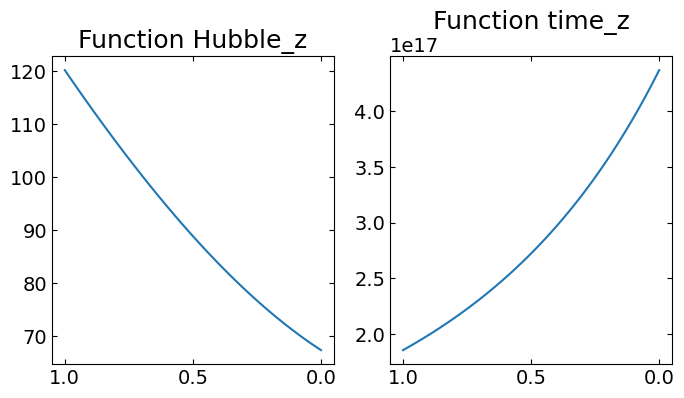

In [12]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

z_range = jnp.linspace(0,1,100)
axs[0].plot(z_range, Physics.Hubble_z(z_range, Params())/(Params.km/Params.s/Params.Mpc))
axs[0].set_title('Function Hubble_z')
axs[1].plot(z_range, Physics.time_z(z_range, Params())/Params.s)
axs[1].set_title('Function time_z')
print(Physics.time_z(z_range, Params())[0]/Params.s, Params.t0/Params.s)
print(Physics.Hubble_z(z_range, Params())[0]/(Params.km/Params.s/Params.Mpc), Params.H0/(Params.km/Params.s/Params.Mpc))

for ax in axs:
    ax.invert_xaxis()

plt.show(); plt.close()

Light neutrino: 50.0 meV. Heavy neutrino: 70.80960386840194 meV
50.0 53.58835232367808


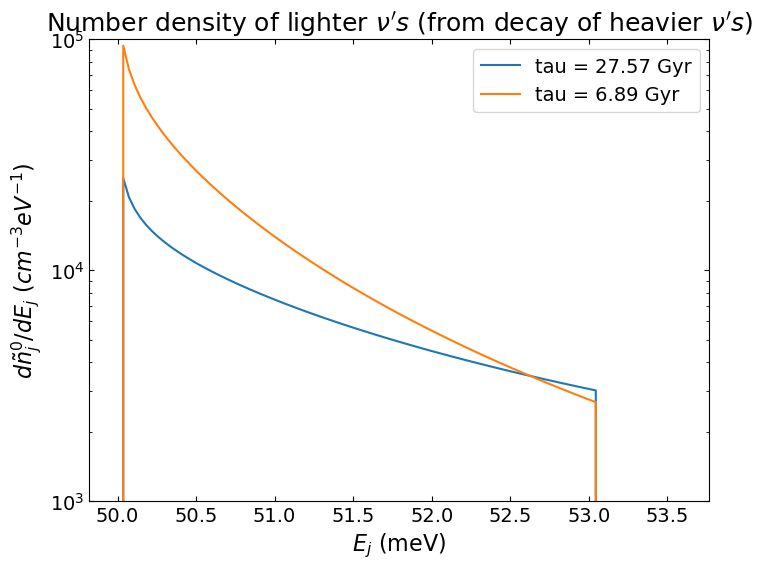

In [13]:
# Neutrino and mediator masses.
m_lightest = 50.*Params.meV
ordering = 'NO'
m_j, _, m_i = Physics.neutrino_masses(m_lightest, ordering, Params())
m_x = 0.*Params.meV
print(f'Light neutrino: {m_j/Params.meV} meV. Heavy neutrino: {m_i/Params.meV} meV')

# Energy Range for nu_1 produced by decays of nu_3 (see text above sect. 5.1.2).
E_j_lower = m_j
E_j_upper = Ptolemy.E_star(m_i, m_j, m_x)*1.01
print(E_j_lower/Params.meV, E_j_upper/Params.meV)
E_range = jnp.linspace(E_j_lower, E_j_upper, 100)
tau_i = 2*Params.t0
n0_i = 56/Params.cm**3

# X_array = jnp.linspace(-40, 80, 100)*meV  # K_e - K0_end (meV)


### Number density, energy spectrum.
fig, ax = plt.subplots(figsize=(8,6))

for tau_i in (2.*Params.t0, Params.t0/2.):
    nj_spec = jnp.array([Ptolemy.dndE_decay(E, m_j, m_i, m_x, tau_i, n0_i, Params()) for E in E_range])
    nj_spec_plot = nj_spec*Params.cm**3*Params.eV
    ax.semilogy(E_range/Params.meV, nj_spec_plot, label=f'tau = {(tau_i/Params.Gyr):.2f} Gyr')

ax.set_title(r"Number density of lighter $\nu's$ (from decay of heavier $\nu's$)")
ax.set_xlabel(r'$E_j$ (meV)')
ax.set_ylabel(r'$d\tilde{n}_j^0 / dE_j$ $(cm^{-3} eV^{-1})$')
ax.set_ylim(1e3, 1e5)

plt.legend()
plt.show(); plt.close()

Max. number density n0_j: 49.27


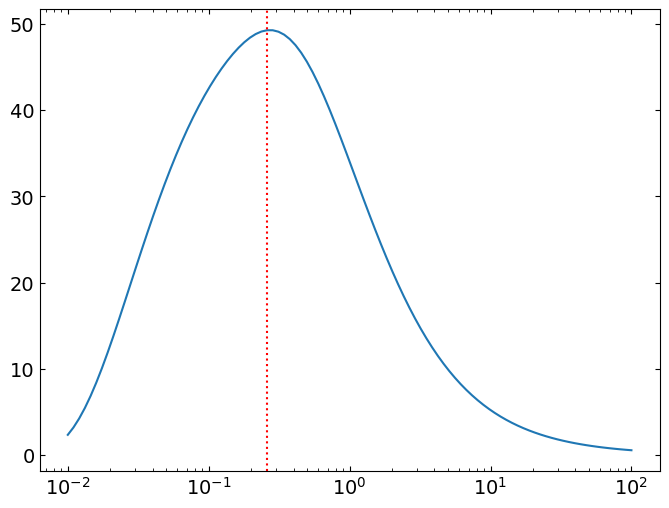

"Optimal" lifetime at 0.26 * t0 
This only happend for large enough E_lower, see comment below.


In [14]:
### Neutrino number densities today, for different decay lifetimes.
lifetimes = jnp.geomspace(1e-1, 1e3, 100)*Params.t0/10
final_n0_j = jnp.zeros(len(lifetimes))
for j, tau_i in enumerate(lifetimes):
    
    n_j_spectrum = jnp.zeros(len(E_range))
    for i, E_j in enumerate(E_range):
        jax_set_1 = Ptolemy.dndE_decay(E_j, m_j, m_i, m_x, tau_i, n0_i, Params())
        n_j_spectrum = n_j_spectrum.at[i].set(jax_set_1)

    jax_set_2 = jsp.integrate.trapezoid(n_j_spectrum, x=E_range)
    final_n0_j = final_n0_j.at[j].set(jax_set_2)


fig, ax = plt.subplots(figsize=(8,6))
lifetimes /= Params.t0
final_n0_j *= Params.cm**3
ax.semilogx(lifetimes, final_n0_j)

max_n0_j = jnp.max(final_n0_j)
print(f'Max. number density n0_j: {max_n0_j:.2f}')
ind = jnp.argwhere(final_n0_j==max_n0_j)
opt_tau = lifetimes[ind]
ax.axvline(opt_tau, ls=':', c='r')
plt.show()
print(
    f'"Optimal" lifetime at {opt_tau[0][0]:.2f} * t0 '
    '\n'
    'This only happend for large enough E_lower, see comment below.'
    )
plt.close()

## Fermi-Dirac spectra.

Total nr. density (should be ~112 for one $m_\nu$): 
 56.09

Ratio of nr. density to LambdaCDM (should be ~1): 
 1.00144

Total nr. densities via energy integration: 
 56.33, 56.33, 56.33, 56.33


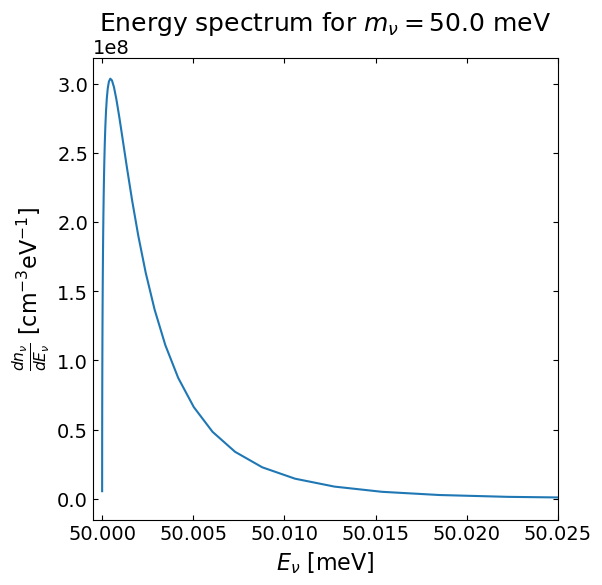

In [26]:
# Neutrino masses
masses_FD = jnp.array([10, 50, 100, 300])*Params.meV

# Momentum sampling (resolution) parameters for Fermi-Dirac spectra
p_start, p_stop, p_num = 0.01*Params.T_CNB, 100*Params.T_CNB, 100

# Energy spectrum for chosen neutrino mass
p_FD, dndp_FD, E_FD, dndE_FD, v_FD = Ptolemy.dndE_Fermi_Dirac(
    masses_FD, p_start, p_stop, p_num, Params())

v_unit = Params.km/Params.s*Params.c

phase_space_factor = Params.g_nu / (2 * Params.Pi**2)

# Check if momentum distribution is normalized correctly
integrand = phase_space_factor * dndp_FD
total_p_nr = jsp.integrate.trapezoid(integrand, p_FD)
print(r'Total nr. density (should be ~112 for one $m_\nu$):', 
      '\n',
      f'{total_p_nr*Params.cm**3:.2f}')
print(
    '\nRatio of nr. density to LambdaCDM (should be ~1):', 
    '\n',
    f'{(total_p_nr/Params.N0):.5f}')

# Equivalently, check if energy distribution is normalized correctly
integrand = phase_space_factor * dndE_FD
total_E_nr = jsp.integrate.trapezoid(integrand, E_FD, axis=-1)
formatted_total_E_nr = [f'{x*Params.cm**3:.2f}' for x in total_E_nr]
print(f'\nTotal nr. densities via energy integration:', 
      '\n',
      ', '.join(formatted_total_E_nr))

# Plot spectrum
plt.figure(figsize=(6,6))
m_idx = 1
plt.title(rf'Energy spectrum for $m_\nu={masses_FD[m_idx]/Params.meV}$ meV')
plt.xlabel(r'$E_\nu$ [meV]')
plt.ylabel(r'$\frac{dn_\nu}{dE_\nu}$ [$\mathrm{cm}^{-3} \mathrm{eV}^{-1}$]')
plt.plot(E_FD[m_idx]/Params.meV, dndE_FD[m_idx]*(Params.eV*Params.cm**3))
plt.xlim(0.99999*masses_FD[m_idx]/Params.meV, masses_FD[m_idx]/Params.meV*1.0005)
plt.show(); plt.close()

In [21]:
# Check if integration (i.e. sum) over the rates/energies gives expected 
# results of ~4/yr and ~8/yr for Dirac and Majorana neutrinos, respectively

def events_per_year_p(nature, nu_masses, p_start, p_stop, p_num, args):

    # Get momenta, energies and velocities
    p_FD, *_ = Ptolemy.dndE_Fermi_Dirac(nu_masses, p_start, p_stop, p_num, args)

    # Compute Fermi-Dirac values
    f_FD = Physics.Fermi_Dirac(p_FD, args)

    # Prefactor for event rate
    pre = nature * args.U_ei_AbsSq_NO * args.sigma_avg * args.N_T
    phase_space_factor = args.g_nu / (2 * args.Pi**2)

    # Integral for event rate
    dndp = p_FD**2 * f_FD

    integral = jsp.integrate.trapezoid(dndp, x=p_FD, axis=-1)

    return pre * phase_space_factor * integral


def events_per_year(nature, nu_masses, p_start, p_stop, p_num, mode, args):

    # Get momenta, energies and velocities
    p_FD, dndp_FD, E_FD, dndE_FD, _ = Ptolemy.dndE_Fermi_Dirac(nu_masses, p_start, p_stop, p_num, args)

    # Constant factors
    pre = nature * args.U_ei_AbsSq_NO * args.sigma_avg * args.N_T
    phase_space_factor = args.g_nu / (2 * args.Pi**2)

    if mode == 'momentum':
        integral = jsp.integrate.trapezoid(dndp_FD, x=p_FD, axis=-1)
    if mode == 'energy':
        integral = jsp.integrate.trapezoid(dndE_FD, x=E_FD, axis=-1)

    return pre * phase_space_factor * integral


def check_event_FD(nu_masses, ordering, nature, p_start, p_stop, p_num, args):
    
    E_FD, integrand = Ptolemy.dGamma_CNB_dE_e_FD(
        nu_masses, ordering, nature, p_start, p_stop, p_num, args)

    integral = jsp.integrate.trapezoid(integrand, x=E_FD, axis=-1)

    return integral


# Neutrino parameters
m_lightest = 100*Params.meV
ordering = 'NO'
nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params())
nature = 1.
p_start, p_stop, p_num = 0.01*Params.T_CNB, 100*Params.T_CNB, 50

events_p = events_per_year_p(nature, nu_masses, p_start, p_stop, p_num, Params())
print(f'Events/year (via momentum) for m_lightest={m_lightest/Params.meV} meV:',
      '\n',
      events_p*Params.yr,
      jnp.sum(events_p*Params.yr))

mode = 'momentum'
events_E = events_per_year(nature, nu_masses, p_start, p_stop, p_num, mode, Params())
print(f'Events/year (via energy) for m_lightest={m_lightest/Params.meV} meV:',
      '\n',
      events_E*Params.yr,
      jnp.sum(events_E*Params.yr))

events_FD = check_event_FD(nu_masses, ordering, nature, p_start, p_stop, p_num, Params())
print(f'Events/year (via final function) for m_lightest={m_lightest/Params.meV} meV:',
      '\n',
      events_FD*Params.yr,
      jnp.sum(events_FD*Params.yr))

#? why do the last two methods differ???

# note: does not seem to matter if integral is linear or log

# note: fixed a bunch of mistakes and confusions related to sigma_avg
# now see if array of velocities work, when using the sigma_avg_19 value
#! careful! need to think about how this assumption is justified or still
#! reflects the underlying physics.

#? maybe it's okay to have the velocity averaged cross section for a proof-of-concept first
#? the momentum information is in the p array anyway, for the FD case and for the
#? grav. modified case

Events/year (via momentum) for m_lightest=100.0 meV: 
 [2.77754785 1.21135347 0.09054561] 4.0794469273772025
Events/year (via energy) for m_lightest=100.0 meV: 
 [2.77754785 1.21135347 0.09054561] 4.0794469273772025
Events/year (via final function) for m_lightest=100.0 meV: 
 [2.82675596 1.23281428 0.09214978] 4.15172002122134


## X_range and related interpolations

ic| X_range.shape: (10748,)
ic| spectra_jnp.shape: (3, 10748)
ic| start_idx: Array(6269, dtype=int64)
ic| X_range[start_idx]/Params.meV: Array(49.99534754, dtype=float64)
ic| zeros_before: Array(6269, dtype=int64)
    zeros_after: Array(4429, dtype=int64)
ic| zeros_before+zeros_after+E_FD.shape[-1] == len(X_range): Array(True, dtype=bool)


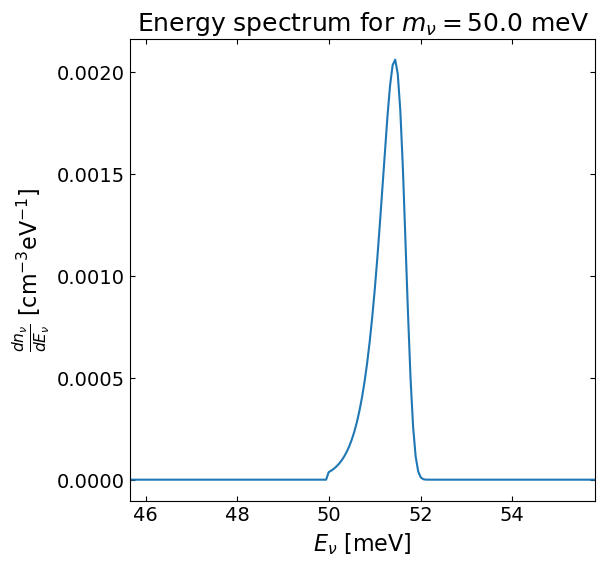

In [48]:
#
# Determine length of x-axis range based on resolution of Fermi-Dirac spectra
#

# Neutrino parameters
m_lightest = 50*Params.meV
ordering = 'NO'
nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params())
nature = 1.

# Momentum sampling (resolution) parameters for Fermi-Dirac spectra
p_start, p_stop, p_num = 0.01*Params.T_CNB, 100*Params.T_CNB, 50

# Energy resolutions 
E_FD, _ = Ptolemy.dGamma_CNB_dE_e_FD(
    nu_masses, ordering, nature, p_start, p_stop, p_num, Params())
resos = jnp.abs((jnp.max(E_FD, axis=-1) - jnp.min(E_FD, axis=-1))) / (E_FD.shape[-1] - 1)

# Highest resolution of energy arrays, i.e. step size
reso = jnp.max(resos)

# Total x-axis range for spectrum, like in PTOLEMY et al. (2019) Fig. 1, 
# labeled as: E_e - E_{end,0} [meV]
X_start, X_stop = -300*Params.meV, 300*Params.meV

# Determine resolution of axis on determined step size above
X_points = int(jnp.abs((X_stop - X_start)) / reso + 1)
X_range = jnp.linspace(X_start, X_stop, X_points)

ic(X_range.shape)


E_FD, spec_FD = Ptolemy.dGamma_CNB_dE_e_FD(
    nu_masses, ordering, nature, p_start, p_stop, p_num, Params())

spectra_FD_true = []
for m_nu, Es, specs in zip(nu_masses, E_FD, spec_FD):
    
    # Interpolate and set values outside of energy range to zero
    spec_FD_sync = Ptolemy.jax_interp(X_range, Es, specs)

    #! this integration routine seems to break the spectrum. 
    #? let's try padding the original one (see above) with zeros left and right,
    #? until size of X_range has been reached?

    spectra_FD_true.append(spec_FD_sync)

spectra_jnp = jnp.array(spectra_FD_true)

ic(spectra_jnp.shape)


# Plot spectrum
# plt.figure(figsize=(6,6))
# m_idx = 0

# plt.plot(X_range/Params.meV, spectra_jnp[m_idx]*(Params.eV*Params.cm**3))

# plt.xlim(0.9999*nu_masses[m_idx]/Params.meV, nu_masses[m_idx]/Params.meV*1.01)

# plt.title(rf'Energy spectrum for $m_\nu={nu_masses[m_idx]/Params.meV}$ meV')
# plt.xlabel(r'$E_\nu$ [meV]')
# plt.ylabel(r'$\frac{dn_\nu}{dE_\nu}$ [$\mathrm{cm}^{-3} \mathrm{eV}^{-1}$]')
# plt.show(); plt.close()

spec_zeros = jnp.zeros_like(X_range)

start_idx = jnp.argmin(jnp.abs(X_range - E_FD[0,0]))
ic(start_idx)
ic(X_range[start_idx]/Params.meV)

zeros_before = start_idx
zeros_after = len(X_range) - zeros_before - E_FD.shape[-1]
ic(zeros_before, zeros_after)
ic(zeros_before+zeros_after+E_FD.shape[-1] == len(X_range))

zero_arr_before = jnp.zeros(zeros_before)
zero_arr_after = jnp.zeros(zeros_after)

X_spec_FD = jnp.concatenate((zero_arr_before, spec_FD[0,:], zero_arr_after))

# Plot spectrum
plt.figure(figsize=(6,6))

plt.plot(X_range/Params.meV, X_spec_FD*(Params.eV*Params.cm**3))

plt.xlim(0.9*nu_masses[m_idx]/Params.meV, nu_masses[m_idx]/Params.meV*1.1)

plt.title(rf'Energy spectrum for $m_\nu={nu_masses[0]/Params.meV}$ meV')
plt.xlabel(r'$E_\nu$ [meV]')
plt.ylabel(r'$\frac{dn_\nu}{dE_\nu}$ [$\mathrm{cm}^{-3} \mathrm{eV}^{-1}$]')
plt.show(); plt.close()

#? why does a simple concatenation of zeros change the height and width of 
#? the spectrum...something wrong with constructing X_range?
#! X_range only for mass which gave highest resolution!
#! that's why we were doing the interpolation in the first place...

## PTOLEMY electron spectra plots

In [ ]:
@jax.jit
def Gaussian_kernel(X_range, sigma, args):

    # Normalization for Gaussian
    norm = jnp.sqrt(2*args.Pi)*sigma  

    return jnp.exp(-X_range**2 / (2 * sigma**2)) / norm


@jax.jit
def Gaussian_convolution_1D(X_range, array_to_convolve, Gaussian_sigma, args):

    # X-range differences for the Gaussian in the convolution integral
    X_diff = X_range[:, None] - X_range[None, :]

    # Functions to be convolved
    f1 = array_to_convolve[:, None]
    g1 = Gaussian_kernel(X_diff, Gaussian_sigma, args)

    # Convolution by integration
    array_convolved = jsp.integrate.trapezoid(f1 * g1, x=X_range, axis=0)
    
    # # Find peak values
    # peak_original = jnp.max(array_to_convolve)
    # peak_convolved = jnp.max(array_convolved)

    # # Adjust, i.e. normalize, convolved spectrum based on peak values
    # adjustment_factor = peak_original / peak_convolved
    # array_convolved_normalized = array_convolved * adjustment_factor
    

    # # Find areas under curves
    # area_original = jsp.integrate.trapezoid(array_to_convolve, x=X_range)
    # area_convolved = jsp.integrate.trapezoid(array_convolved, x=X_range)

    # # # Adjust, i.e. normalize, convolved spectrum based on areas
    # adjustment_factor = area_original / area_convolved
    # array_convolved_normalized = array_convolved * adjustment_factor

    array_convolved_normalized = array_convolved

    return array_convolved_normalized


def ZhangZhang2018_overdensity(m_nu):
    return 76.5 * m_nu**2.21


def PLOT_Ptolemy_electron_spectra(spectra_list):

    # Define the set of valid spectra options
    valid_spectra = [
        "tritium_bkg_true", 
        "tritium_bkg_smeared",
        "fermi_dirac_true",
        "fermi_dirac_smeared",
        "total_true",
        "total_smeared",
        "gaussian_kernel"]

    # Helper function to get a string of valid options
    def get_valid_options_str():
        return f"Valid options: {', '.join(valid_spectra)}"

    # Check if spectra_list is empty or contains invalid items
    if not spectra_list:
        raise ValueError("spectra_list is empty. " + get_valid_options_str())
    elif any(spectrum not in valid_spectra for spectrum in spectra_list):
        raise ValueError("Invalid input in spectra_list. " + get_valid_options_str())


    # Lighest neutrino masses to anchor hierarchy
    m_lightest_arr = [10*Params.meV, 50*Params.meV]

    # PTOLEMY experiment energy resolutions
    Delta_arr = [10*Params.meV, 20*Params.meV, 50*Params.meV]

    # Explore both mass orderings
    orders = [
        'NO', 
        'IO'
    ]
    colors = ['red', 'blue']

    # Neutrino nature
    nature = 1.  # 1 = Dirac neutrinos, 2 = Majorana neutrinos

    # Momentum sampling (resolution) parameters for Fermi-Dirac spectra
    p_start, p_stop, p_num = 0.01*Params.T_CNB, 100*Params.T_CNB, 50

    # Plot 4 combinations for the parameters of the PTOLEMY experiment setup
    plt.figure(figsize=(12,10))
    for i in range(4):
        ax = plt.subplot(221 + i)

        if i == 0:  # upper left plot
            m_lightest = m_lightest_arr[0]
            Delta = Delta_arr[0]
        elif i == 1:  # upper right plot
            m_lightest = m_lightest_arr[1]
            Delta = Delta_arr[0]
        elif i == 2:  # lower left plot
            m_lightest = m_lightest_arr[1]
            Delta = Delta_arr[1]
        elif i == 3:  # lower right plot
            m_lightest = m_lightest_arr[1]
            Delta = Delta_arr[2]

        y_unit = Params.yr*Params.eV

        for ordering, color in zip(orders, colors):

            # Get neutrino masses
            nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params())
            m_nu_L, m_nu_M, m_nu_H = nu_masses

            # Gaussian standard deviation
            sigma = Delta/jnp.sqrt(8*jnp.log(2))

            #
            # Determine length of x-axis range based on resolution of Fermi-Dirac spectra
            #

            # Energy resolutions 
            E_FD, _ = Ptolemy.dGamma_CNB_dE_e_FD(
                nu_masses, ordering, nature, p_start, p_stop, p_num, Params())
            resos = jnp.abs((jnp.max(E_FD, axis=-1) - jnp.min(E_FD, axis=-1))) / (E_FD.shape[-1] - 1)

            # Highest resolution of energy arrays, i.e. step size
            reso = jnp.max(resos)

            # Total x-axis range for spectrum, like in PTOLEMY et al. (2019) Fig. 1, 
            # labeled as: E_e - E_{end,0} [meV]
            X_start, X_stop = -300*Params.meV, 300*Params.meV

            # Determine resolution of axis on determined step size above
            X_points = int(jnp.abs((X_stop - X_start)) / reso + 1)
            X_range = jnp.linspace(X_start, X_stop, X_points)

            # Convert to energy range
            E_range = X_range + Params.m_e + Params.K0_end


            if ordering == "NO" and "gaussian_kernel" in spectra_list:
                Gaussian = Gaussian_kernel(X_range, sigma, Params())
                ax.semilogy(
                    (X_range/Params.meV)-150, Gaussian,
                    color='orange', ls='dashdot', alpha=0.5, label=f'Gaussian') 

                # Check if Gaussian is normalized
                # Gaussian_area = jsp.integrate.trapezoid(Gaussian, x=X_range)
                # ic(Gaussian_area)



            # =============== #
            # Tritium Spectra #
            # =============== #

            # Tritium beta-decay (background) spectrum
            T_beta_spec = Ptolemy.Beta_decay_spectrum(
                E_range, nu_masses, ordering, Params())

            # Convolved (i.e. smeared) Trititum beta-decay spectrum
            T_beta_spec_conv_norm = Gaussian_convolution_1D(
                E_range, T_beta_spec, sigma, Params())


            # =================== #
            # Fermi-Dirac Spectra #
            # =================== #

            if "fermi_dirac_true" or "fermi_dirac_smeared" or "total_smeared" in spectra_list:

                # Fermi-Dirac spectrum for neutrino masses
                E_FD, spec_FD = Ptolemy.dGamma_CNB_dE_e_FD(
                    nu_masses, ordering, nature, p_start, p_stop, p_num, Params())

                spectra_FD_true = []
                spectra_FD_conv = []
                for m_nu, Es, specs in zip(nu_masses, E_FD, spec_FD):
                    
                    # Interpolate and set values outside of energy range to zero
                    spec_FD_sync = Ptolemy.jax_interp(X_range, Es, specs)

                    # Boost by gravitational clustering and convolve
                    boost = 1 + ZhangZhang2018_overdensity(m_nu)
                    spec_FD_sync *= boost

                    if "fermi_dirac_true" in spectra_list:
                        spectra_FD_true.append(spec_FD_sync)

                    if "fermi_dirac_smeared" or "total_smeared" in spectra_list:
                        
                        spec_FD_conv_norm = Gaussian_convolution_1D(
                            X_range, spec_FD_sync, sigma, Params())
                    
                        spectra_FD_conv.append(spec_FD_conv_norm)

                spectra_FD_true = jnp.sum(jnp.array(spectra_FD_true), axis=0)
                spectra_FD_conv = jnp.sum(jnp.array(spectra_FD_conv), axis=0)

                if "fermi_dirac_true" in spectra_list:
                    ax.semilogy(
                        X_range/Params.meV, spectra_FD_true*y_unit,
                        color=color, ls='solid', alpha=0.7, label=f'{ordering}')
                    
                    # Events per year for unconvolved (original) dndE_FD
                    events_yr_FD = jsp.integrate.trapezoid(
                        spec_FD, x=E_FD, axis=-1)*Params.yr
                    print(f'\033[1m Fermi-Dirac (true, over E_FD) \033[0m'
                          '\n',
                          f'Events per year: {events_yr_FD}, {events_yr_FD.sum():.2f} (sum)')

                    # Event per year using total X_range                    
                    events_yr_FD_X_range = jsp.integrate.trapezoid(
                        spectra_FD_true, x=X_range, axis=-1)*Params.yr
                    print(f'\033[1m Fermi-Dirac (true, over X_range) \033[0m'
                          '\n',
                          f'Events per year: {events_yr_FD_X_range}, {events_yr_FD_X_range.sum():.2f} (sum)')

                    #? does the convolution modify the total rate?

                    #? just sanity check if integration of spec_FD over E_FD returns 4 or 8 per year

                if "fermi_dirac_smeared" in spectra_list:
                    ax.semilogy(
                        X_range/Params.meV, spectra_FD_conv*y_unit,
                        color=color, ls='dashed', alpha=0.7, label=f'{ordering}')


            # ========================= #
            # Plot Selection of Spectra #
            # ========================= #

            if "tritium_bkg_true" in spectra_list:
                ax.semilogy(
                    X_range/Params.meV, T_beta_spec*y_unit,
                    color=color, ls='dotted')#ls=(0, (5, 10)))
                
            if "tritium_bkg_smeared" in spectra_list:
                ax.semilogy(
                    X_range/Params.meV, T_beta_spec_conv_norm*y_unit,
                    color=color, ls='solid', alpha=0.7, label=f'{ordering}')

            if "total_smeared" in spectra_list:
                total_smeared = T_beta_spec_conv_norm + spectra_FD_conv
                ax.semilogy(
                    X_range/Params.meV, total_smeared*y_unit,
                    color=color, ls='solid', alpha=0.7, label=f'{ordering}')

            ax.text(0.95, 0.95, 
                    rf'$m_\mathrm{{lightest}}={m_lightest/Params.meV:.0f}$ meV'
                    '\n'
                    rf'$\Delta={Delta/Params.meV:.0f}$ meV',
                    fontsize=10, va='top', ha='right', 
                    transform=ax.transAxes)

            # ax.legend(loc='center left', prop={'size': 10})
            ax.set_xlabel(r'$E_e - E_{\mathrm{end},0}$ [meV]', fontsize=16)
            ax.set_ylabel(r'$d\Gamma / dE_e$ $(yr^{-1} eV^{-1})$', fontsize=16)
            ax.set_xlim(-280,300)
            # ax.set_xlim(-20,70)
            # plt.xlim(0.99*m_lightest/Params.meV, m_lightest/Params.meV*1.1)
            ax.set_ylim(1e-2, 1e11)
            
    plt.suptitle('PTOLEMY electron energy spectra')
    plt.tight_layout()
    plt.show(); plt.close()


PLOT_Ptolemy_electron_spectra(
    spectra_list=(
        # "tritium_bkg_true", 
        # "tritium_bkg_smeared",
        "fermi_dirac_true",
        "fermi_dirac_smeared",
        # "total_true",
        # "total_smeared",
        # "gaussian_kernel",
        )
    )